In [18]:
from more_itertools import pairwise
import itertools
import igraph as ig
import random
import colorsys
from datetime import datetime, timedelta
from collections import Counter
import pickle
import pandas as pd
from pprint import pprint

In [2]:
period = 'april2022'
data_path = f'../data/{period}/processed'

In [3]:
def to_stop_tuples(tratte_data):
    # Pairwise iteration
    for t1, t2 in pairwise(tratte_data.itertuples(index=False)):
        if t1.route_id == t2.route_id and t2.stop_sequence > t1.stop_sequence:
            if t1.departure_time == '' or t2.arrival_time == '':
                yield (t1.route_id, t1.stop_id, t2.stop_id, 0)
            else:
                departure_time1 = datetime.strptime(t1.departure_time,"%H:%M:%S").time()
                departure_time1 = timedelta(hours=departure_time1.hour, minutes=departure_time1.minute, seconds=departure_time1.second)    
                arrival_time2 = datetime.strptime(t2.arrival_time,"%H:%M:%S").time()
                arrival_time2 = timedelta(hours=arrival_time2.hour, minutes=arrival_time2.minute, seconds=arrival_time2.second)         
                yield (t1.route_id, t1.stop_id, t2.stop_id, (arrival_time2 - departure_time1).seconds)


In [4]:
def rand_color():
    h, s, l = random.random(), 0.5 + random.random()/2.0, 0.4 + random.random()/5.0
    r, g, b = [int(256*i) for i in colorsys.hls_to_rgb(h,l,s)]
    return (r / 255, g / 255, b / 255) 

In [5]:
with open(f'{data_path}/trenord.pickle', 'rb') as data:
    calendar, routes, stop_times, stops, trips, tratte, weeks = pickle.load(data)

In [6]:
# Tratte data
tratte_tuple = {(route_id, stop_id1, stop_id2) for route_id, stop_id1, stop_id2, _ in to_stop_tuples(tratte)}

# Routes data
routes = { route_id for route_id, _, _ in tratte_tuple }
# Routes color
routes_color = { route_id : rand_color() for route_id in routes }

In [7]:
from itertools import groupby
from statistics import mean

keyfunct = key=lambda v: (lambda route_id1, stop_id1, stop_id2, _: (route_id1, stop_id1, stop_id2))(*v)
grouped = groupby(sorted(to_stop_tuples(tratte), key=keyfunct), key=keyfunct)
tratta_time = { k : mean(tratta_time for _, _, _, tratta_time in g) for k, g in grouped }

In [9]:
g = ig.Graph(directed=True)

g.add_vertices(
    n = stops.stop_id, 
    attributes = {
        'label': stops.stop_name,
        'lat': stops.stop_lat,
        'lon': stops.stop_lon
    }
)

g.add_edges(
    es = [(stop_id1, stop_id2) for _, stop_id1, stop_id2 in tratte_tuple],
    attributes = {
        'label': [route_id for route_id, _, _ in tratte_tuple],
        'color': [routes_color[route_id] for route_id, _, _ in tratte_tuple],
        'time_second': [tratta_time[route_id, stop_id1, stop_id2]  for route_id, stop_id1, stop_id2 in tratte_tuple]
    }
)

In [10]:
# Adding num_train
g.es['num_train'] = 0.0
for l1, l2 in pairwise(weeks.itertuples(index=False)):
    if l1.service_id == l2.service_id and l1.trip_id == l2.trip_id and l2.stop_sequence > l1.stop_sequence:
        edge = g.es.select(
            _source=g.vs(name=l1.stop_id)[0].index,
            _target=g.vs(name=l2.stop_id)[0].index,
            label=l1.route_id
            )
        if len(edge) == 1:
            edge[0]['num_train'] = edge[0]['num_train'] + ( l1.times_in_week / 2.0)


In [11]:
# ATTENZIONE risultano più oggetti "arco" per la stessa coppia di nodi
sou = g.vs.find(label = 'STRADELLA').index
edge = g.es.select(_source = sou)
for i in edge:
    print(i.vertex_tuple)

(igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 291, {'name': '2790', 'label': 'STRADELLA', 'lat': 45.079286, 'lon': 9.300823}), igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 63, {'name': '457', 'label': 'ARENA PO', 'lat': 45.08214, 'lon': 9.360389}))
(igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 291, {'name': '2790', 'label': 'STRADELLA', 'lat': 45.079286, 'lon': 9.300823}), igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 119, {'name': '746', 'label': 'BRONI', 'lat': 45.066163, 'lon': 9.258878}))
(igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 291, {'name': '2790', 'label': 'STRADELLA', 'lat': 45.079286, 'lon': 9.300823}), igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 63, {'name': '457', 'label': 'ARENA PO', 'lat': 45.08214, 'lon': 9.360389}))
(igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 291, {'name': '2790', 'label': 'STRADELLA', 'lat': 45.079286, 'lon': 9.300823}), igraph.Vertex(<igraph.Graph object at 0x7faffa8315e0>, 11

In [ ]:
for e in g.es(_source=g.vs(label='SARONNO')[0].index):
    print(e)

In [12]:
g.summary()


'IGRAPH DN-- 428 1688 -- \n+ attr: label (v), lat (v), lon (v), name (v), color (e), label (e), num_train (e), time_second (e)'

In [13]:
# Save the graph
save_path = '../data/graphs/' + period + '.graphml' 
g.write_graphml(save_path)

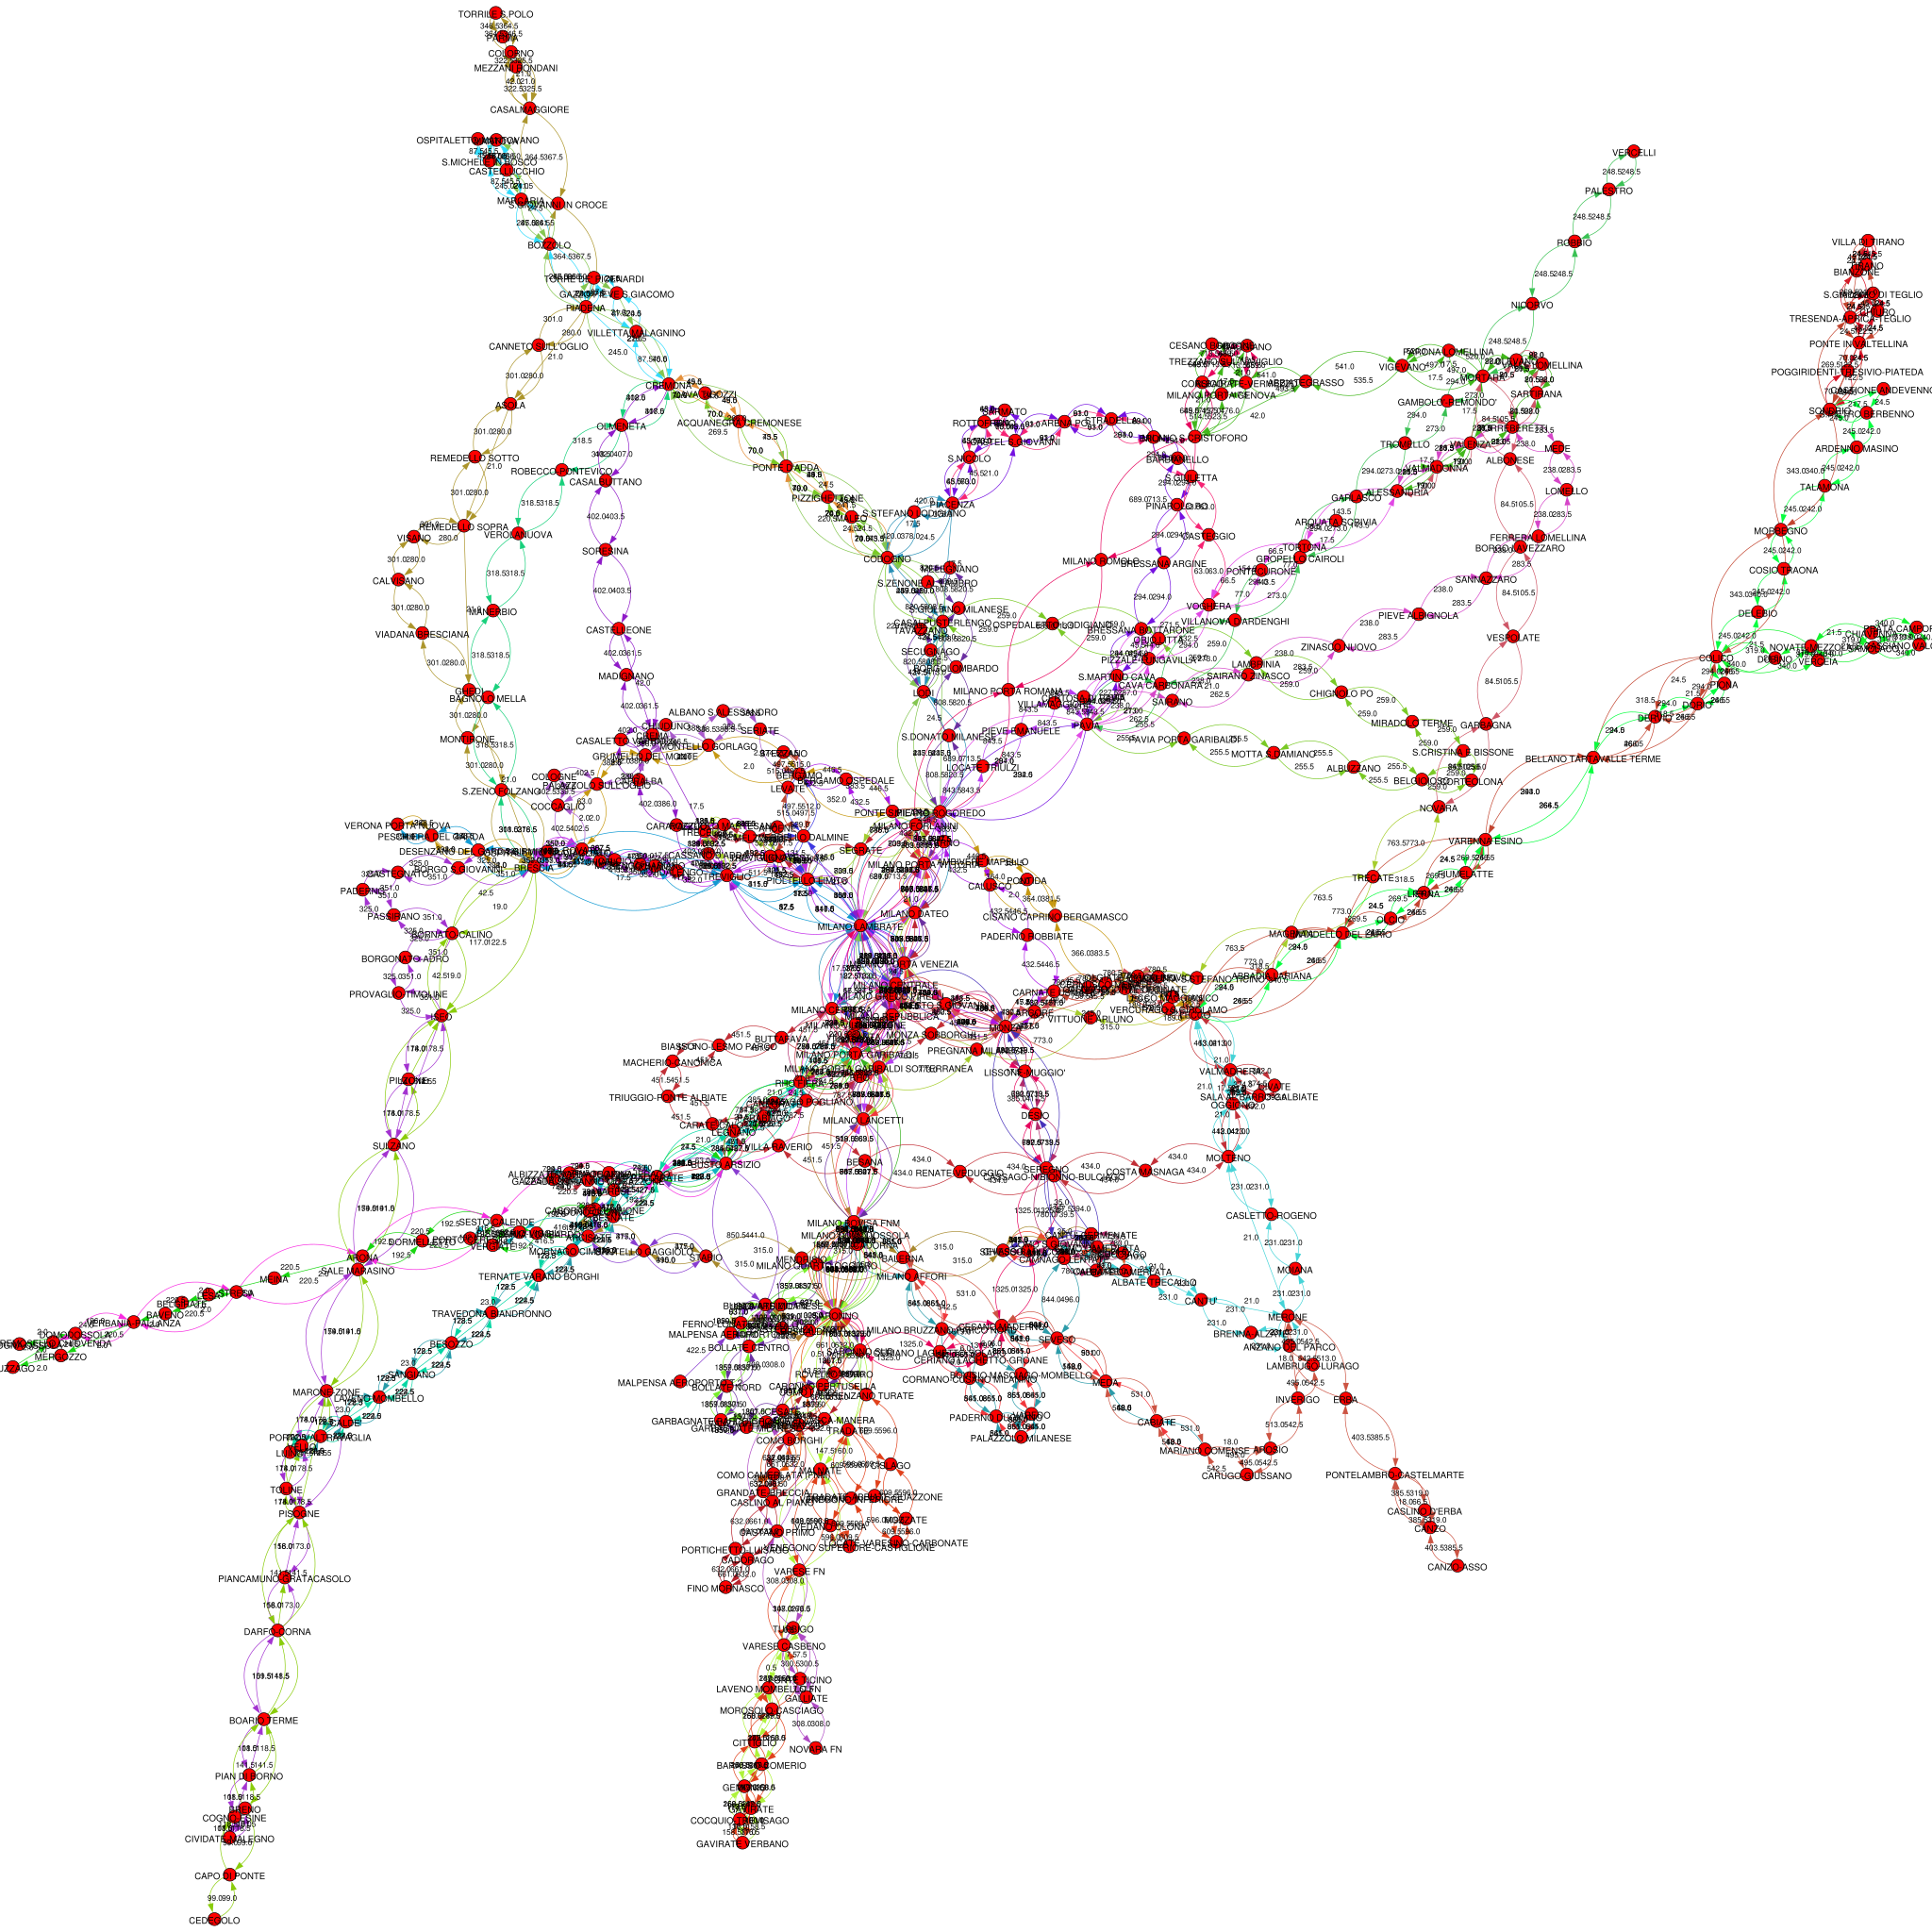

In [14]:
visual_style = {} #Python dictionary
visual_style["edge_label"] = g.es['num_train']
visual_style["layout"] = g.layout_auto()

ig.plot(g, bbox=(0, 0, 3000, 3000), **visual_style)